In [127]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go

import nltk 
from nltk.corpus import  stopwords
import string
import re 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import accuracy_score,classification_report,confusion_matrix,precision_score

In [128]:
df = pd.read_csv('spam.csv',encoding='latin-1')

In [129]:
# Data Cleaning

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [131]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [132]:
df.columns = ['target','text']

In [133]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [134]:
enc = LabelEncoder()
df['target'] = enc.fit_transform(df['target'])

In [135]:
# check for missing values
df.isna().sum()

target    0
text      0
dtype: int64

In [136]:
# check for duplicated values
df.duplicated().sum()

403

In [137]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [138]:
df.duplicated().sum()

0

In [139]:
df.shape

(5169, 2)

In [140]:
# EDA

In [141]:
# What is the percentage of ham and spam
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

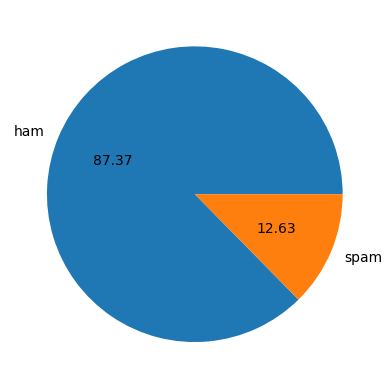

In [142]:
plt.pie(df['target'].value_counts(),labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [143]:
# spam_ham_count = df['target'].value_counts()
# fig = px.pie(df,values=spam_ham_count.values,names=spam_ham_count.index)
# fig.show()

In [144]:
# imbalanced dataset

In [145]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mamta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [146]:
df['no_of_char'] = df['text'].apply(len)

In [147]:
df.head()

,target,text,no_of_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [148]:
# num of words
df["no_of_words"] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [149]:
df.head()

,target,text,no_of_char,no_of_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [150]:
df["no_of_sent"] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [151]:
df.head()

,target,text,no_of_char,no_of_words,no_of_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [152]:
df.describe()

,target,no_of_char,no_of_words,no_of_sent
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.453279,1.947185
std,0.332253,58.236293,13.324793,1.362406
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,28.000000


In [153]:
# for ham 
df[df['target']==0][["no_of_char","no_of_words","no_of_sent"]].describe()

,no_of_char,no_of_words,no_of_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [154]:
df[df['target']==1][["no_of_char","no_of_words","no_of_sent"]].describe()


,no_of_char,no_of_words,no_of_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


In [155]:
# ham and spam character comparison
fig = go.Figure()
fig.add_trace(go.Histogram(x=df[df['target']==0]["no_of_char"],name="ham_char"))
fig.add_trace(go.Histogram(x=df[df['target']==1]["no_of_char"],name='spam_char'))
fig.update_layout(barmode='overlay',xaxis_title_text='characters',yaxis_title_text='count')
fig.show()

In [156]:
# ham and spam words comparison
fig = go.Figure()
fig.add_trace(go.Histogram(x=df[df['target']==0]["no_of_words"],name="ham_words"))
fig.add_trace(go.Histogram(x=df[df['target']==1]["no_of_words"],name='spam_words'))
fig.update_layout(barmode='overlay',xaxis_title_text='words',yaxis_title_text='count')
fig.show()

In [157]:
# heatmpap of correlation
fig = px.imshow(df.drop("text",axis=1).corr(),text_auto=True,color_continuous_scale='RdBu')
fig.show()

In [158]:
# Data Preprocessing involve steps like
# lower case
# removing special characters
# tokenization 
# removing stopwords and punctuations
# stemming 



In [159]:
ps_stem = PorterStemmer()
lemma = WordNetLemmatizer()
# def text_transform(text):
#     text = text.lower()
#     text = nltk.word_tokenize(text)
#     y= []
#     for i in text:
#         if i.isalnum():
#             y.append(i)
#     text =y[:]
#     y.clear()
#     for i in text:
#         if i not in stopwords.words('english') and i not in string.punctuation:
#             y.append(i)
#     text=y[:]
#     y.clear()
#     for i in text:
#         y.append(ps_stem.stem(i))
        
#     return " ".join(y)

In [160]:

def text_transform(text):
    text = re.sub(r'[^a-zA-Z\s]',' ',text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = word_tokenize(text)
    text= " ".join(text)
    text = text.lower()
    # text = [ps_stem.stem(word) for word in text.split() if word not in stopwords.words('english')]
    text = [lemma.lemmatize(word) for word in text.split() if word not in stopwords.words('english')]
    text= " ".join(text)
        
    return text

In [161]:
df['processed_text'] = df['text'].apply(text_transform)

In [162]:
df.head()

,target,text,no_of_char,no_of_words,no_of_sent,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think go usf life around though


In [163]:
# from wordcloud import Wordcloud
# wc = Wordcloud(width=500,height=500,min_font_size=10,backgroud_color="white")
# spam_wc = wc.generate(df[df['target']==1]['processed_text'].str.cat(sep=" "))
# plt.imshow(spam_wc)

In [164]:
spam_corpus=[]
ham_corpus=[]
for message in df[df['target']==1]['processed_text'].tolist():
    for words in message.split():
        spam_corpus.append(words)
for message in df[df['target']==0]['processed_text'].tolist():
    for words in message.split():
        ham_corpus.append(words)
    

In [165]:
from collections import Counter
df_most_spam_common = pd.DataFrame(Counter(spam_corpus).most_common(50),columns=['words','frequency'])
df_most_ham_common = pd.DataFrame(Counter(ham_corpus).most_common(50),columns=['words','frequency'])

fig=px.bar(df_most_spam_common,x='words',y='frequency')
fig.show()

In [166]:
fig=px.bar(df_most_ham_common,x='words',y='frequency')
fig.show()

In [167]:
X = df['processed_text']
tfidf= TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(X)

In [168]:
y = df['target']

In [169]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.2)

In [170]:
mnb= MultinomialNB()
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)

In [171]:
print(accuracy_score(y_test,y_pred))

0.9680851063829787


In [172]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       885
           1       1.00      0.78      0.88       149

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034



In [173]:
print(confusion_matrix(y_test,y_pred))

[[885   0]
 [ 33 116]]


In [174]:
print(precision_score(y_test,y_pred))

1.0


In [176]:
df[df['target']==1]['text'].iloc[0]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [178]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
y_pred = lr_model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9555125725338491


In [179]:
param_grid= {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'C': 10, 'solver': 'liblinear'}


In [180]:
best_model = grid_search.best_estimator_

In [181]:
best_model.fit(X_train,y_train)
best_y_pred = best_model.predict(X_test)
print(accuracy_score(y_test,best_y_model))

0.9738878143133463


In [182]:
print(classification_report(y_test,best_y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       885
           1       0.97      0.85      0.91       149

    accuracy                           0.97      1034
   macro avg       0.97      0.92      0.95      1034
weighted avg       0.97      0.97      0.97      1034



In [183]:
print(confusion_matrix(y_pred,best_y_pred))

[[903  24]
 [  0 107]]


In [184]:
best_model.predict(tfidf.transform(["Urgent: Your bank account has been compromised! Click this link immediately to secure your funds: fakebanking-site.com 🚨 Failure to act will result in account suspension!"]))

array([1])

In [185]:
# tfidf,logisticRegression
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(best_model,open('model.pkl','wb'))